# Coordinates

This file contains the processing of coordinates data in the yelp restaurant dataset.

**Goal:** Provide a coordinates_processing function, which can be used in main.ipynb.

## 1. Get the coordinates dataset

The coordinates dataset only contains price, rating, review_count, name, id, coordinates (latitude, longitude) columns. Extraction of this dataset is shown in main.ipynb.

In [1]:
import pickle
import requests
import json
import os
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt

In [2]:
origin_data_file = '../Dataset/coordinates_data'

with open(origin_data_file, 'rb') as inFile:
    origin_data = pickle.load(inFile)

display(origin_data.head())
print("origin_data.shape: {0}".format(origin_data.shape))

,id,name,latitude,longitude,rating,review_count,price
0,bwCj2AcoOroZfCTxb6rCcg,A Better Burger,36.689639,-83.108766,3.5,6,2
1,S9S9kFJSkmfpbjFForCWLQ,El Castillo,36.726337,-83.099858,4.0,2,1
2,np8uV1xll22Yr-Q-B-ImkA,Rooster's Pub,36.758436,-83.027057,4.5,4,1
3,HGY1ojoLu07P_ky2LeRguQ,Redstone Restaurant,36.689259,-82.753040,4.5,3,1
4,J5XS3VmxnLKhNlpiwDJ-3A,Little Mexico,36.859367,-82.756744,4.0,5,1


origin_data.shape: (5119, 7)


## 2. Get census tract data
Extract cencus tract information in Virginia for further processing.

**Census tract geographic data**: The census tract data is downloaded from [2010 Census Gazetteer Files](https://www.census.gov/geo/maps-data/data/gazetteer2010.html).

In [3]:
tract_file = "../dataset/Gaz_tracts_national.txt"

with open(tract_file, 'r') as infile:
    tract_df = pd.read_csv(infile, sep = "\t", dtype={'GEOID':object})

# Drop not in VA
tract_df = tract_df.loc[tract_df['USPS'] == 'VA'].reset_index(drop=True)

tract_df.columns = tract_df.columns.str.lower()

In [4]:
tract_df.head()

,usps,geoid,pop10,hu10,aland,awater,aland_sqmi,awater_sqmi,intptlat,intptlong
0,VA,51001090100,2941,4517,18529985,37927447,7.154,14.644,37.945138,-75.362044
1,VA,51001090200,6156,4259,187805809,36543634,72.512,14.110,37.953865,-75.503313
2,VA,51001090300,2335,1221,128431098,61781712,49.588,23.854,37.887621,-75.662907
3,VA,51001090400,6234,2687,193719276,35803197,74.795,13.824,37.752376,-75.598061
4,VA,51001090500,2849,1361,65940306,39496129,25.460,15.250,37.814134,-75.696946


**Cencus tract data**: including sex by age, household income and age by language. These data is downloaded from [Census Reporter](https://censusreporter.org/profiles/04000US51-virginia/).

- **Sex by age data processing**

In [5]:
sex_by_age_path = '../dataset/sex_by_age/'

# Process data.csv
with open(os.path.join(sex_by_age_path, 'data.csv'), 'r') as infile:
    sex_by_age_df = pd.read_csv(infile)

# Drop US and Virginia rows
sex_by_age_df.drop(index=[0, 1], inplace=True)
sex_by_age_df.reset_index(inplace=True, drop=True)

# Get column names from metadata.json
with open(os.path.join(sex_by_age_path, 'metadata.json'), 'r') as infile:
    metadata = json.load(infile)

isMaleNow = False
change_cols = {}
for col in metadata['tables']['B01001']['columns'].items():
    if(col[1]['name'] == 'Total:'):
        change_cols[col[0]] = 'total_population'
    elif(col[1]['name'] == 'Male:'):
        change_cols[col[0]] = 'total_male_population'
        isMaleNow = True
    elif(col[1]['name'] == 'Female:'):
        change_cols[col[0]] = 'total_female_population'
        isMaleNow = False
    elif(isMaleNow):
        change_cols[col[0]] = 'male_'+col[1]['name'].lower().replace(' ', '_')
    else:
        change_cols[col[0]] = 'female_'+col[1]['name'].lower().replace(' ', '_')
        
sex_by_age_df.rename(columns=change_cols, inplace=True)

# Drop error and name columns
error_cols = ['name']
for col in sex_by_age_df.columns:
    if(col[0] == 'B'):
        error_cols.append(col)

sex_by_age_df.drop(columns=error_cols, inplace=True)

# Alter geoid so that it can merge with tract data
for i, row in sex_by_age_df.iterrows():
    sex_by_age_df.loc[i, 'geoid'] = row['geoid'][7:]

In [6]:
sex_by_age_df.head(2)

,geoid,total_population,total_male_population,male_under_5_years,male_5_to_9_years,male_10_to_14_years,male_15_to_17_years,male_18_and_19_years,male_20_years,male_21_years,...,female_50_to_54_years,female_55_to_59_years,female_60_and_61_years,female_62_to_64_years,female_65_and_66_years,female_67_to_69_years,female_70_to_74_years,female_75_to_79_years,female_80_to_84_years,female_85_years_and_over
0,51001090100,2919,1354,78,67,96,7,25,9,0,...,129,143,82,84,70,86,83,103,56,38
1,51001090200,6407,3157,251,195,111,60,0,0,8,...,250,195,69,215,210,53,200,88,48,100


In [7]:
# Put sex_by_age data into census tract dataframe
tract_df = pd.merge(tract_df, sex_by_age_df, on='geoid', how='left')

- **Household income data processing**

In [8]:
household_path = '../dataset/household_income/'

# Process data.csv
with open(os.path.join(household_path, 'data.csv'), 'r') as infile:
    household_df = pd.read_csv(infile)

# Drop US and Virginia rows
household_df.drop(index=[0, 1], inplace=True)
household_df.reset_index(inplace=True, drop=True)

# Get column names from metadata.json
with open(os.path.join(household_path, 'metadata.json'), 'r') as infile:
    metadata = json.load(infile)

change_cols = {}
for col in metadata['tables']['B19001']['columns'].items():
    if(col[1]['name'] == 'Total:'):
        change_cols[col[0]] = 'total_household_income'
    else:
        change_cols[col[0]] = 'house_'+col[1]['name'].lower().replace(' ', '_').replace('$', '')
        
household_df.rename(columns=change_cols, inplace=True)

# Drop error and name columns
error_cols = ['name']
for col in household_df.columns:
    if(col[0] == 'B'):
        error_cols.append(col)

household_df.drop(columns=error_cols, inplace=True)

# Alter geoid so that it can merge with tract data
for i, row in household_df.iterrows():
    household_df.loc[i, 'geoid'] = row['geoid'][7:]

In [9]:
household_df.head(2)

,geoid,total_household_income,"house_less_than_10,000","house_10,000_to_14,999","house_15,000_to_19,999","house_20,000_to_24,999","house_25,000_to_29,999","house_30,000_to_34,999","house_35,000_to_39,999","house_40,000_to_44,999","house_45,000_to_49,999","house_50,000_to_59,999","house_60,000_to_74,999","house_75,000_to_99,999","house_100,000_to_124,999","house_125,000_to_149,999","house_150,000_to_199,999","house_200,000_or_more"
0,51001090100,1382,120,41,77,79,104,92,65,85,74,108,172,145,77,64,23,56
1,51001090200,2638,177,115,216,279,198,151,223,68,234,206,275,266,122,18,15,75


In [10]:
# Put household_income data into census tract dataframe
tract_df = pd.merge(tract_df, household_df, on='geoid', how='left')

- **Age by language data processing**

In [11]:
language_path = '../dataset/age_by_language/'

# Process data.csv
with open(os.path.join(language_path, 'data.csv'), 'r') as infile:
    language_df = pd.read_csv(infile)

# Drop US and Virginia rows
language_df.drop(index=[0, 1], inplace=True)
language_df.reset_index(inplace=True, drop=True)

# Get column names from metadata.json
with open(os.path.join(language_path, 'metadata.json'), 'r') as infile:
    metadata = json.load(infile)

prefix = ""
change_cols = {}
for col in metadata['tables']['B16007']['columns'].items():
    if(col[1]['name'] == 'Total:'):
        change_cols[col[0]] = 'total'
    elif(col[1]['name'] == '5 to 17 years:'):
        change_cols[col[0]] = 'total_5_to_17'
        prefix = '5_to_17_'
    elif(col[1]['name'] == '18 to 64 years:'):
        change_cols[col[0]] = 'total_18_to_64'
        prefix = '18_to_64_'
    else:
        change_cols[col[0]] = prefix+col[1]['name'].lower().replace(' ', '_')
        
language_df.rename(columns=change_cols, inplace=True)

# Drop error, name and total columns
error_cols = ['name', 'total']
for col in language_df.columns:
    if(col[0] == 'B'):
        error_cols.append(col)

language_df.drop(columns=error_cols, inplace=True)

# Alter geoid so that it can merge with tract data
for i, row in language_df.iterrows():
    language_df.loc[i, 'geoid'] = row['geoid'][7:]

In [12]:
language_df.head(2)

,geoid,total_5_to_17,5_to_17_speak_only_english,5_to_17_speak_spanish,5_to_17_speak_other_indo-european_languages,5_to_17_speak_asian_and_pacific_island_languages,5_to_17_speak_other_languages,total_18_to_64,18_to_64_speak_only_english,18_to_64_speak_spanish,18_to_64_speak_other_indo-european_languages,18_to_64_speak_asian_and_pacific_island_languages,18_to_64_speak_other_languages,18_to_64_65_years_and_over:,18_to_64_speak_only_english,18_to_64_speak_spanish,18_to_64_speak_other_indo-european_languages,18_to_64_speak_asian_and_pacific_island_languages,18_to_64_speak_other_languages
0,51001090100,298,298,0,0,0,0,1656,1595,37,24,0,0,818,769,0,49,0,0
1,51001090200,869,762,61,46,0,0,3681,3421,237,23,0,0,1271,1247,24,0,0,0


In [13]:
# Put age_by_language data into census tract dataframe
tract_df = pd.merge(tract_df, language_df, on='geoid', how='left')

In [14]:
# Final tract_df
tract_df.head()

,usps,geoid,pop10,hu10,aland,awater,aland_sqmi,awater_sqmi,intptlat,intptlong,...,18_to_64_speak_spanish,18_to_64_speak_other_indo-european_languages,18_to_64_speak_asian_and_pacific_island_languages,18_to_64_speak_other_languages,18_to_64_65_years_and_over:,18_to_64_speak_only_english,18_to_64_speak_spanish,18_to_64_speak_other_indo-european_languages,18_to_64_speak_asian_and_pacific_island_languages,18_to_64_speak_other_languages
0,VA,51001090100,2941,4517,18529985,37927447,7.154,14.644,37.945138,-75.362044,...,37.0,24.0,0.0,0.0,818.0,769.0,0.0,49.0,0.0,0.0
1,VA,51001090200,6156,4259,187805809,36543634,72.512,14.110,37.953865,-75.503313,...,237.0,23.0,0.0,0.0,1271.0,1247.0,24.0,0.0,0.0,0.0
2,VA,51001090300,2335,1221,128431098,61781712,49.588,23.854,37.887621,-75.662907,...,58.0,3.0,23.0,0.0,508.0,507.0,0.0,1.0,0.0,0.0
3,VA,51001090400,6234,2687,193719276,35803197,74.795,13.824,37.752376,-75.598061,...,883.0,249.0,0.0,0.0,1043.0,1008.0,35.0,0.0,0.0,0.0
4,VA,51001090500,2849,1361,65940306,39496129,25.460,15.250,37.814134,-75.696946,...,172.0,122.0,7.0,0.0,449.0,449.0,0.0,0.0,0.0,0.0


In [15]:
tract_df.columns

Index(['usps', 'geoid', 'pop10', 'hu10', 'aland', 'awater', 'aland_sqmi',
       'awater_sqmi', 'intptlat', 'intptlong', 'total_population',
       'total_male_population', 'male_under_5_years', 'male_5_to_9_years',
       'male_10_to_14_years', 'male_15_to_17_years', 'male_18_and_19_years',
       'male_20_years', 'male_21_years', 'male_22_to_24_years',
       'male_25_to_29_years', 'male_30_to_34_years', 'male_35_to_39_years',
       'male_40_to_44_years', 'male_45_to_49_years', 'male_50_to_54_years',
       'male_55_to_59_years', 'male_60_and_61_years', 'male_62_to_64_years',
       'male_65_and_66_years', 'male_67_to_69_years', 'male_70_to_74_years',
       'male_75_to_79_years', 'male_80_to_84_years', 'male_85_years_and_over',
       'total_female_population', 'female_under_5_years',
       'female_5_to_9_years', 'female_10_to_14_years', 'female_15_to_17_years',
       'female_18_and_19_years', 'female_20_years', 'female_21_years',
       'female_22_to_24_years', 'female_25_to_29_

## 3. Add new features to coordinates dataset
This section includes:
1. For each business, decide which census tract it belongs to: Call [FCC Area API](https://geo.fcc.gov/api/census/#!/area/get_area) to get geoid of each business.
2. Add corresponding census tract features.

In [16]:
url = 'https://geo.fcc.gov/api/census/area'
def get_geoid(lat, lon):
    """For coordinate (lat, lon), decide which census tract it belongs to.
    """
    url_params = {
        'lat': lat,
        'lon': lon,
        'format': 'json'
    }
    
    response = requests.request('GET', url, params=url_params)
    result = response.json()['results']
    if(result == []):
        geoid = get_geoid(lon, lat)
    else:
        geoid = result[0]['block_fips'][:-4]
    return geoid

In [17]:
geo_biz_data = pd.DataFrame(origin_data)
geo_biz_data = geo_biz_data.assign(geoid=np.zeros(origin_data.shape[0]))

In [18]:
for i, row in origin_data.iterrows():
    if(i % 300 == 0):
        print("Calculate row {0}...".format(i))
    lat, lon = row[['latitude', 'longitude']]
    geo_biz_data.loc[i, 'geoid'] = get_geoid(lat, lon)    

Calculate row 0...
Calculate row 300...
Calculate row 600...
Calculate row 900...
Calculate row 1200...
Calculate row 1500...
Calculate row 1800...
Calculate row 2100...
Calculate row 2400...
Calculate row 2700...
Calculate row 3000...
Calculate row 3300...
Calculate row 3600...
Calculate row 3900...
Calculate row 4200...
Calculate row 4500...
Calculate row 4800...
Calculate row 5100...


In [19]:
geo_biz_data = pd.merge(geo_biz_data, tract_df, on='geoid')

In [20]:
geo_biz_data.head()

,id,name,latitude,longitude,rating,review_count,price,geoid,usps,pop10,...,18_to_64_speak_spanish,18_to_64_speak_other_indo-european_languages,18_to_64_speak_asian_and_pacific_island_languages,18_to_64_speak_other_languages,18_to_64_65_years_and_over:,18_to_64_speak_only_english,18_to_64_speak_spanish,18_to_64_speak_other_indo-european_languages,18_to_64_speak_asian_and_pacific_island_languages,18_to_64_speak_other_languages
0,bwCj2AcoOroZfCTxb6rCcg,A Better Burger,36.689639,-83.108766,3.5,6,2,51105950500,VA,4914,...,8.0,32.0,0.0,0.0,1074.0,1074.0,0.0,0.0,0.0,0.0
1,S9S9kFJSkmfpbjFForCWLQ,El Castillo,36.726337,-83.099858,4.0,2,1,51105950500,VA,4914,...,8.0,32.0,0.0,0.0,1074.0,1074.0,0.0,0.0,0.0,0.0
2,np8uV1xll22Yr-Q-B-ImkA,Rooster's Pub,36.758436,-83.027057,4.5,4,1,51105950300,VA,5532,...,247.0,41.0,20.0,40.0,979.0,976.0,3.0,0.0,0.0,0.0
3,HGY1ojoLu07P_ky2LeRguQ,Redstone Restaurant,36.689259,-82.753040,4.5,3,1,51169030300,VA,3674,...,0.0,0.0,0.0,0.0,623.0,623.0,0.0,0.0,0.0,0.0
4,J5XS3VmxnLKhNlpiwDJ-3A,Little Mexico,36.859367,-82.756744,4.0,5,1,51195931200,VA,6649,...,142.0,80.0,20.0,0.0,1045.0,1039.0,0.0,0.0,6.0,0.0


**Save geo_biz_data**: Avoid repeatedly calling API.

In [25]:
save_path = '../Dataset/geo_biz_data'

In [26]:
with open(save_path, 'wb') as outfile:
    pickle.dump(geo_biz_data, outfile)

In [28]:
with open(save_path, 'rb') as infile:
    geo_biz_data = pickle.load(infile)

## 4. Generate classifier

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import itertools

In [37]:
# NaN data
geo_biz_data = geo_biz_data.fillna(0)

In [38]:
# Devide train/test data set
X = geo_biz_data.drop(columns=['id', 'name', 'usps', 'geoid', 'price']).values
y = geo_biz_data['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('{0} train + {1} test'.format(len(X_train), len(X_test)))

4092 train + 1024 test


In [39]:
# Feature scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Linear SVM:
accuracy score: 0.6279296875
Normalized confusion matrix
[[0.57777778 0.42222222 0.         0.        ]
 [0.3032368  0.6967632  0.         0.        ]
 [0.12903226 0.87096774 0.         0.        ]
 [0.         1.         0.         0.        ]]


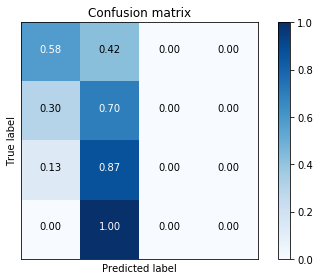

RBF SVM:
accuracy score: 0.6005859375
Normalized confusion matrix
[[0.19753086 0.80246914 0.         0.        ]
 [0.08858603 0.91141397 0.         0.        ]
 [0.03225806 0.96774194 0.         0.        ]
 [0.         1.         0.         0.        ]]


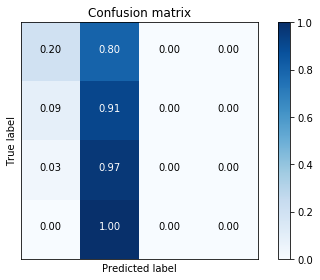

Decision Tree:
accuracy score: 0.6767578125
Normalized confusion matrix
[[0.57777778 0.42222222 0.         0.        ]
 [0.21805792 0.78194208 0.         0.        ]
 [0.12903226 0.87096774 0.         0.        ]
 [1.         0.         0.         0.        ]]


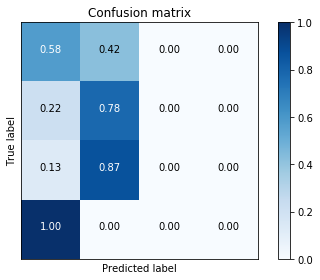

Random Forest:
accuracy score: 0.640625
Normalized confusion matrix
[[0.48395062 0.51604938 0.         0.        ]
 [0.21635434 0.78364566 0.         0.        ]
 [0.06451613 0.93548387 0.         0.        ]
 [1.         0.         0.         0.        ]]


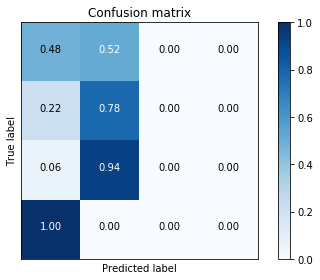

Neural Net:
accuracy score: 0.595703125
Normalized confusion matrix
[[0.46419753 0.51851852 0.01481481 0.00246914]
 [0.2572402  0.71720613 0.02555366 0.        ]
 [0.09677419 0.87096774 0.03225806 0.        ]
 [1.         0.         0.         0.        ]]


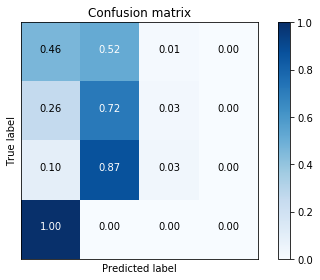

AdaBoost:
accuracy score: 0.6357421875
Normalized confusion matrix
[[0.57283951 0.42222222 0.00246914 0.00246914]
 [0.27086882 0.7120954  0.01703578 0.        ]
 [0.12903226 0.83870968 0.03225806 0.        ]
 [1.         0.         0.         0.        ]]


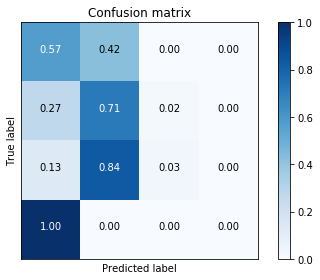

Naive Bayes:
accuracy score: 0.41015625
Normalized confusion matrix
[[0.63950617 0.15555556 0.03950617 0.1654321 ]
 [0.4770017  0.26575809 0.05962521 0.19761499]
 [0.16129032 0.29032258 0.16129032 0.38709677]
 [1.         0.         0.         0.        ]]


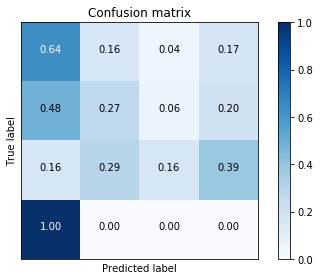

BernoulliNB:
accuracy score: 0.494140625
Normalized confusion matrix
[[0.57037037 0.24197531 0.17283951 0.01481481]
 [0.33901193 0.44122658 0.2044293  0.0153322 ]
 [0.03225806 0.41935484 0.51612903 0.03225806]
 [1.         0.         0.         0.        ]]


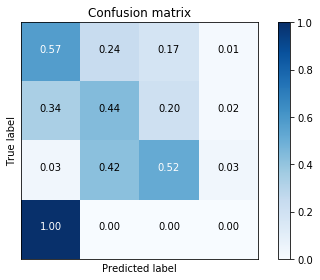

<Figure size 432x288 with 0 Axes>

In [55]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score

h = .02  # step size in the mesh

names = ["Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes",  "BernoulliNB"]

classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=1, C=0.5),
    DecisionTreeClassifier(max_depth=4),
    RandomForestClassifier(max_depth=3, n_estimators=15, max_features=10),
    MLPClassifier(alpha=0.5, hidden_layer_sizes=(1024, 512, 256)),
    AdaBoostClassifier(),
    GaussianNB(),
    BernoulliNB()]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    score = clf.score(X_test, y_test)
    
    print("{0}:".format(name))
    print("accuracy score: {0}".format(score))
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[])
    plt.show()

plt.tight_layout()
plt.show()

## * Generate dataset for Gephi

Now we are going to consider the relation between restaurants as a undirected network graph. Definition of this graph is listed as follows:

**Node:** Each node represents a business, which can be uniquely represented by its id.

**Edge:** Each edge $(u, v)$ represents that the business $u$ is a neighbor of $v$ $(u \neq v)$. Here, we define a parameter, neighbor_dist, as the maximum distance (kilometer) between two neighbors. If the distance of two businesses, $u$ and $v$, is less than neighbor_dist, then we will have edge $(u, v)$ and $(v, u)$.

To calculate the distance between two businesses on the earth, we here adopted the Haversine formula. The code is based on [Haversine formula in Python](https://stackoverflow.com/a/4913653/8163369) on StackOverFlow.

In [ ]:
neighbor_dist = 0.5 # The maximum distance (kilometer) between two neighbors

lats, lons = np.array(data['latitude']), np.array(data['longitude']) # latitude and longitude of businesses
num_samples = data.shape[0] # total number of businesses

edges = []

for i in range(0, num_samples):
    for j in range(i + 1, num_samples):
        dist = haversine(lons[i], lats[i], lons[j], lats[j])
        if(dist < neighbor_dist):
            edges.append([i, j, dist + 0.001])
            edges.append([j, i, dist + 0.001])

In [ ]:
len(edges)

**Output nodes and as .csv file:** for use of Gephi.

In [ ]:
# Generate edges and nodes dataframe as the requirement of Gephi
edges_df = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])

nodes_df = data.rename(columns={'id': 'label'})
nodes_df = nodes_df.assign(id=range(0, num_samples))

display(edges_df.head())
display(nodes_df.head())

In [ ]:
# Write dataframes into files
nodes_file = './Gephi/coordinates_nodes.csv'
edges_file = './Gephi/coordinates_edges.csv'

with open(nodes_file, 'w', encoding='utf-8') as outFile:
    nodes_df.to_csv(outFile, sep=',', encoding='utf-8', index=False)

with open(edges_file, 'w') as outFile:
    edges_df.to_csv(outFile, sep=',', encoding='utf-8', index=False)